In [53]:
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units as u, constants as const
from astropy.cosmology import Planck18
import utils1
import time as time
import emcee
import corner
from multiprocessing import Pool

In [54]:
run functions.py

In [55]:
N_cells = 180 # number of cells of grid for convergence map
Lbox = 5. * u.Mpc
hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
xedges = np.linspace(-hext, hext, N_cells+1)
yedges = np.linspace(-hext, hext, N_cells+1)
xs = 0.5*(xedges[1:]+xedges[:-1])
ys = 0.5*(yedges[1:]+yedges[:-1])
xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
cosmo = astropy.cosmology.Planck18

In [56]:
z_lens1 = 0.071806
z_source1 = 0.1609
x1 = -1.132 # Mpc
y1 = -1.132 # Mpc
Dl1 = cosmo.angular_diameter_distance(z_lens1)

A399 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x1, y0=y1, c=1.013, M=8.7E14, z_lens=z_lens1, z_source=z_source1)

In [57]:
z_lens2 = 0.073664
z_source2 = 0.1609
x2 = 1.132 # Mpc
y2 = 1.132 # Mpc
Dl2 = cosmo.angular_diameter_distance(z_lens2)

A401 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x2, y0=y2, c=1.109, M=10.2E14, z_lens=z_lens2, z_source=z_source2)

In [58]:
dist = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
print(dist)

3.201779505212687


In [59]:
combined_kappa = A399 + A401

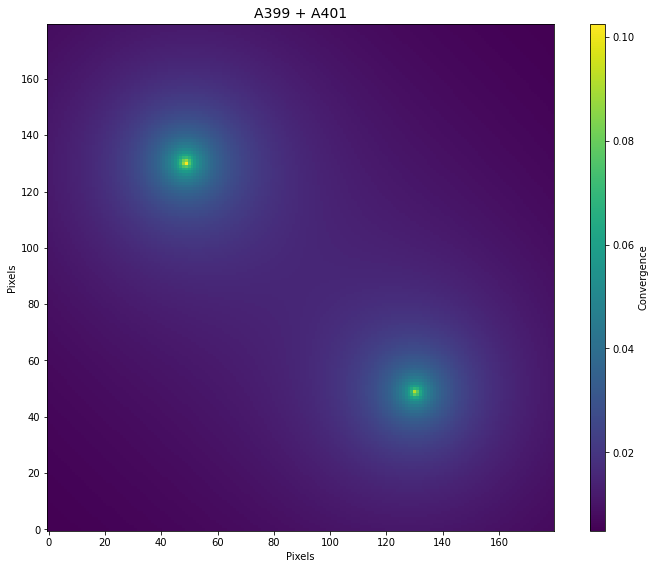

In [60]:
utils1.plot_image(image=combined_kappa, title='A399 + A401', interval_type='simple_norm', cbar_label="Convergence")

SyntaxError: invalid syntax (<ipython-input-61-570cbd411036>, line 1)

In [1]:
combined_shear = shear_from_kappa(kappa=combined_kappa)

NameError: name 'shear_from_kappa' is not defined

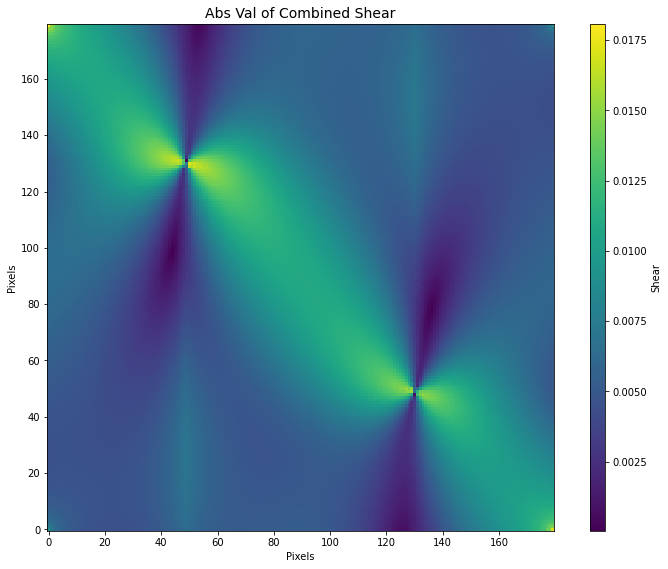

In [20]:
utils1.plot_image(abs(combined_shear), title='Abs Val of Combined Shear', cbar_label="Shear")

In [12]:
# sources: https://arxiv.org/pdf/1411.6525.pdf, https://arxiv.org/pdf/2107.04611.pdf

## MCMC take 2

In [36]:
def get_init(nwalkers):
    """ creates a list of initial values nwalkers long 
    """
    c1 = np.random.uniform(low=0.01, high=3, size=nwalkers) # 1.013, 1.109
    mass1 = np.random.uniform(low=5e14, high=15e14, size=nwalkers)
    x1 = np.random.uniform(low=-1.2, high=-1.0, size=nwalkers)
    y1 = np.random.uniform(low=-1.2, high=-1.0, size=nwalkers)
    c2 = np.random.uniform(low=0.01, high=3, size=nwalkers)
    mass2 = np.random.uniform(low=5e14, high=15e14, size=nwalkers)
    x2 = np.random.uniform(low=1.0, high=1.2, size=nwalkers)
    y2 = np.random.uniform(low=1.0, high=1.2, size=nwalkers)
    
    p0 = []
    for i in range(nwalkers):
        p0.append(np.array([x1[i], y1[i], c1[i], mass1[i], x2[i], y2[i], c2[i], mass2[i]]))
    return np.array(p0)

def log_prior(x):
    """ checking the guess is within range
    """
    x1, y1, c1, mass1, x2, y2, c2, mass2 = x
    if not ((-1.2 < x1 < -1.0) and (-1.2 < y1 < -1.0) and (0.01 < c1 < 3) and (5e14 < mass1 < 15e14) and
            (1.0 < x2 < 1.2) and (1.0 < y2 < 1.2) and (0.01 < c2 < 3) and (5e14 < mass2 < 15e14)):
        return -np.inf
    return 0.0

def log_prob(x, cluster: np.ndarray, sigma: float):
    """ x = p0 (initial guesses in the format of [(x1, y1, c1, mass1, x2, y2, c2, mass2) * 50])
        sigma = std of cluster
    """ 
    x1, y1, c1, mass1, x2, y2, c2, mass2 = x
    
    # Check prior
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    
    # Set values
    N_cells = 180 # number of cells of grid for convergence map
    Lbox = 5. * u.Mpc
    hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
    xedges = np.linspace(-hext, hext, N_cells+1)
    yedges = np.linspace(-hext, hext, N_cells+1)
    xs = 0.5*(xedges[1:]+xedges[:-1])
    ys = 0.5*(yedges[1:]+yedges[:-1])
    xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
    
    z_lens1 = 0.071806
    z_source1 = 0.1609
    A399 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x1, y0=y1, c=c1, M=mass1, z_lens=z_lens1, z_source=z_source1)

    z_lens2 = 0.073664
    z_source2 = 0.1609
    A401 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x2, y0=y2, c=c2, M=mass2, z_lens=z_lens2, z_source=z_source2)

    # Create kappa and gamma maps
    kappa = A399 + A401
    gamma_model = shear_from_kappa(kappa)
    gamma_obs = cluster
    
    # Calculate residuals
    resid_real = (np.square(gamma_obs.real - gamma_model.real)) # 2D array
    resid_imag = (np.square(gamma_obs.imag - gamma_model.imag)) # 2D array
    term1 = np.sum(resid_real) # float
    term2 = np.sum(resid_imag) # float

    return -0.5 * (term1 + term2) / (sigma**2.) # float

# mcmc for different levels of noise

In [37]:
nwalkers = 50
ndim = 8
p0 = get_init(nwalkers)

In [38]:
def mcmc_and_plot(noise):
    # MCMC
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[combined_shear + np.random.normal(0,noise,np.shape(combined_shear)), noise])
        sampler.run_mcmc(p0, 1000, progress=True)
    
    # Plotting
    fig, axes = plt.subplots(8, figsize=(12, 16), sharex=True)
    samples = sampler.get_chain()
    labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], color="k", alpha=0.5)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_xlabel("step number")
        if i == 0:
            ax.axhline(-1.132, color='r',alpha=1)
        elif i == 1:
            ax.axhline(-1.132, color='r',alpha=1)
        elif i == 2:
            ax.axhline(1.013, color='r',alpha=1)
        elif i == 3:
            ax.axhline(8.7E14, color='r',alpha=1)
        elif i == 4:
            ax.axhline(1.132, color='r',alpha=1)
        elif i == 5:
            ax.axhline(1.132, color='r',alpha=1)
        elif i == 6:
            ax.axhline(1.109, color='r',alpha=1)
        elif i == 7:
            ax.axhline(10.2E14, color='r',alpha=1)
        
    return sampler

## noise = 0.01

100%|██████████| 1000/1000 [18:12<00:00,  1.09s/it]


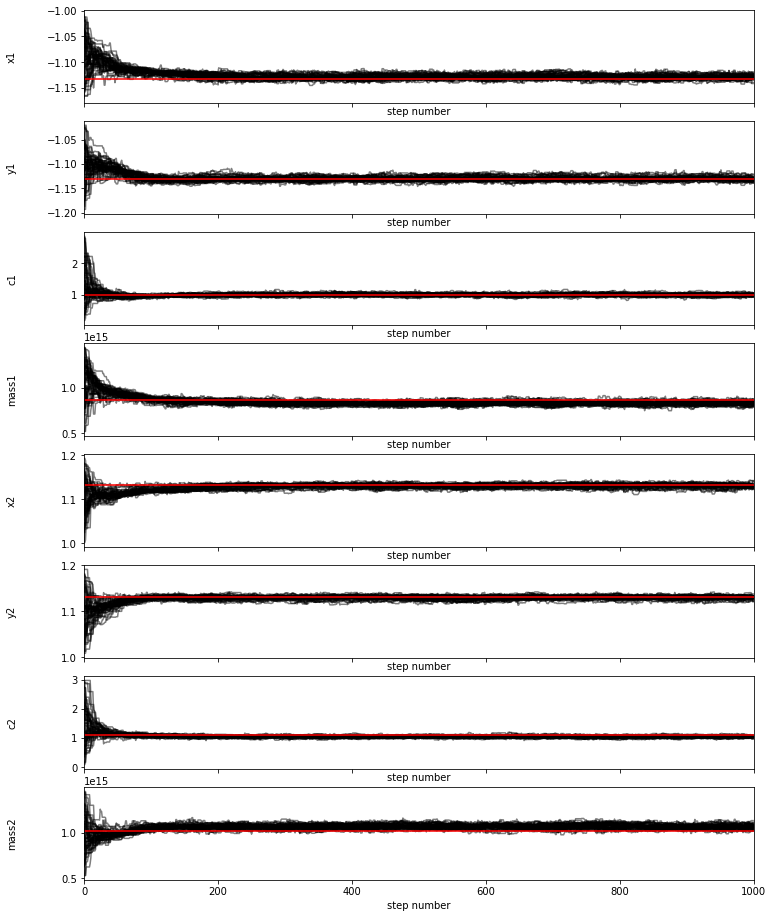

In [45]:
sampler1 = mcmc_and_plot(0.01)

burn-in: 120
thin: 18


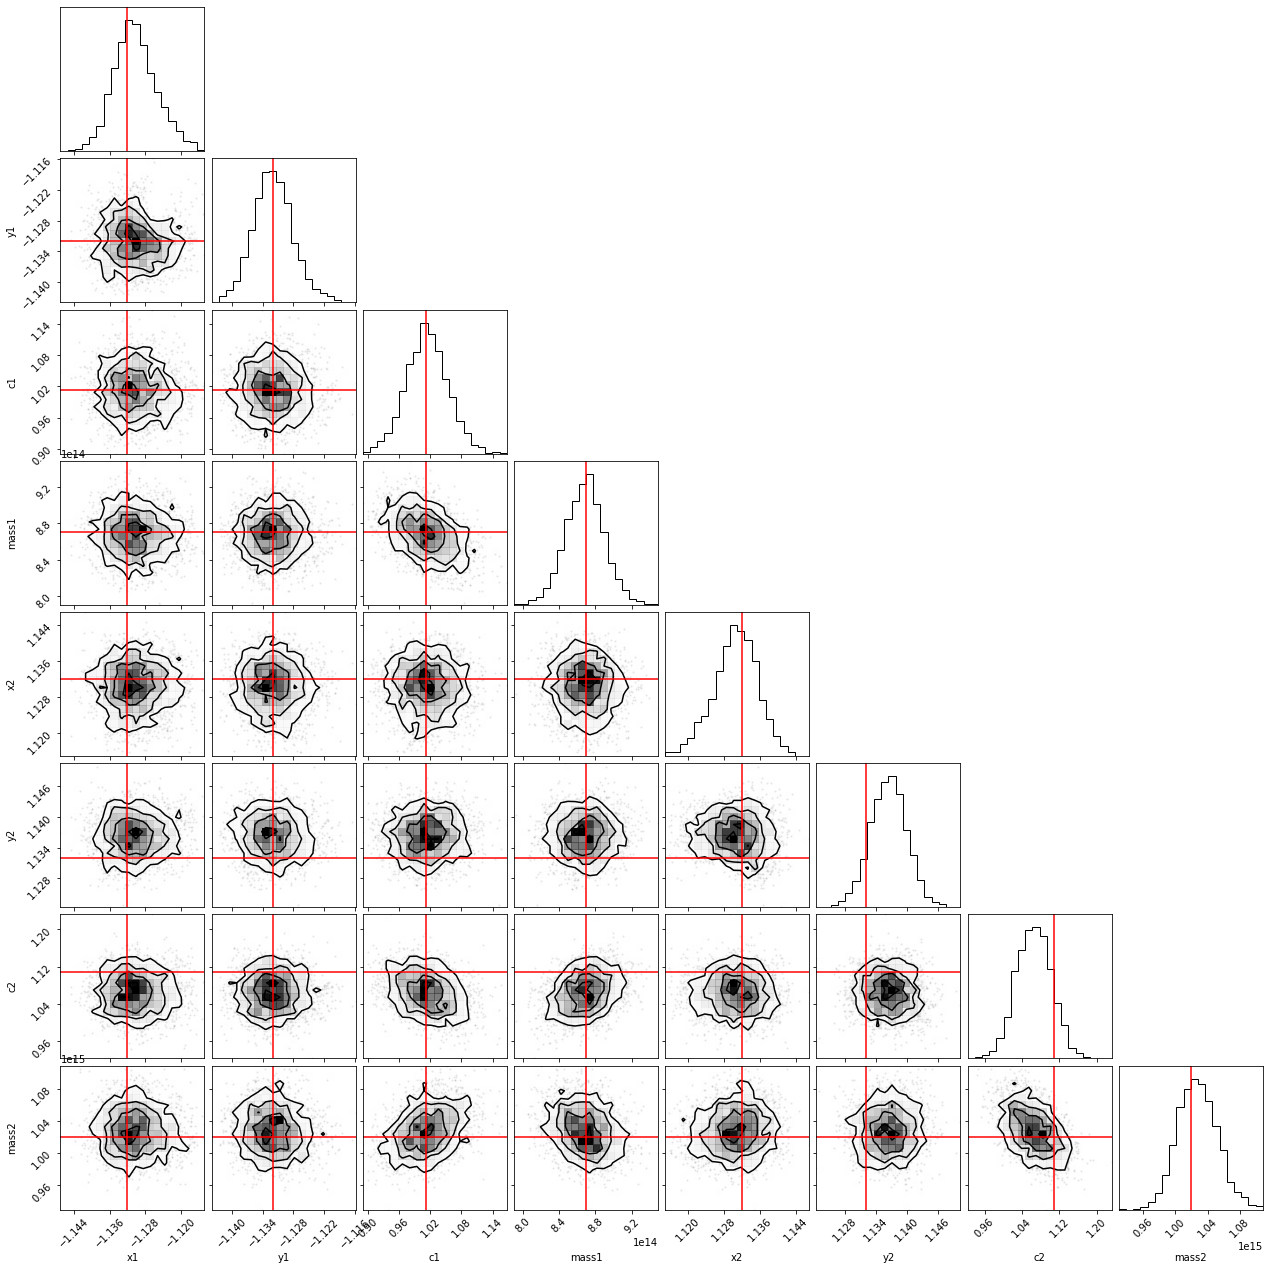

In [33]:
tau = [59.31826362, 49.32135187, 40.14292159, 52.18456313, 60.16214161, 51.42274918, 36.76317183, 56.92461273] #sampler1.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler1.get_chain(discard=burnin, flat=False, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

all_samples = np.concatenate(samples)

labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[-1.132, -1.132, 1.013, 8.7e14, 1.132, 1.132, 1.109, 10.2e14], color='red')

## noise = 0.05

In [25]:
#nwalkers = 50
#ndim = 8
#p0 = get_init(nwalkers)
#noise = np.random.normal(0,0.05,np.shape(combined_shear))
#shear_noise = combined_shear + noise
# with Pool() as pool:
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_noise, 0.05])
    #sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it]


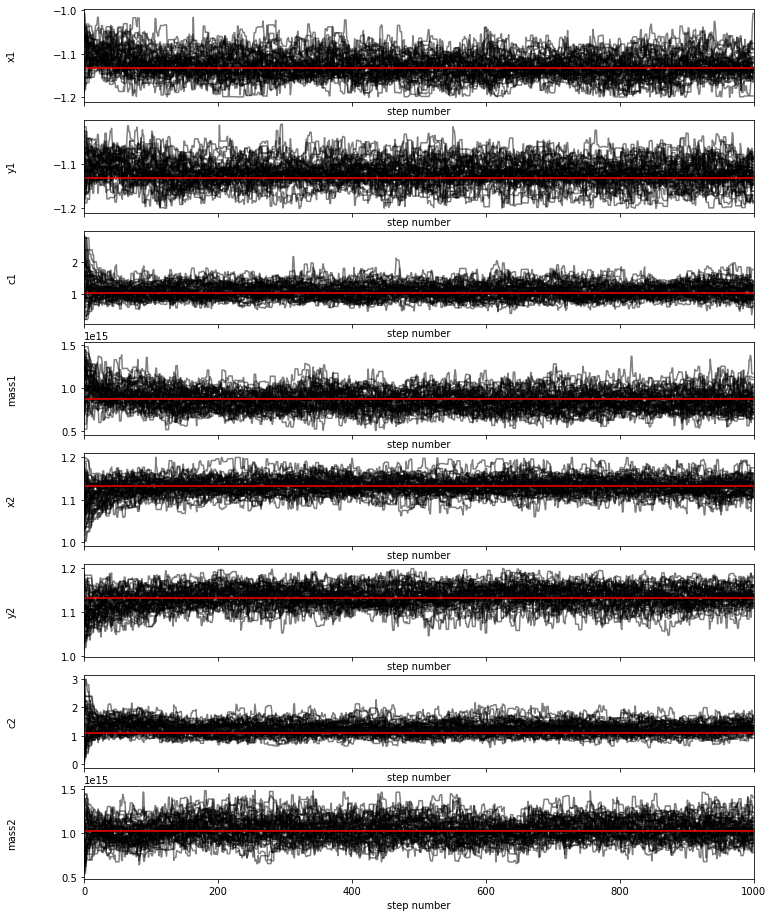

In [39]:
sampler2 = mcmc_and_plot(0.05)

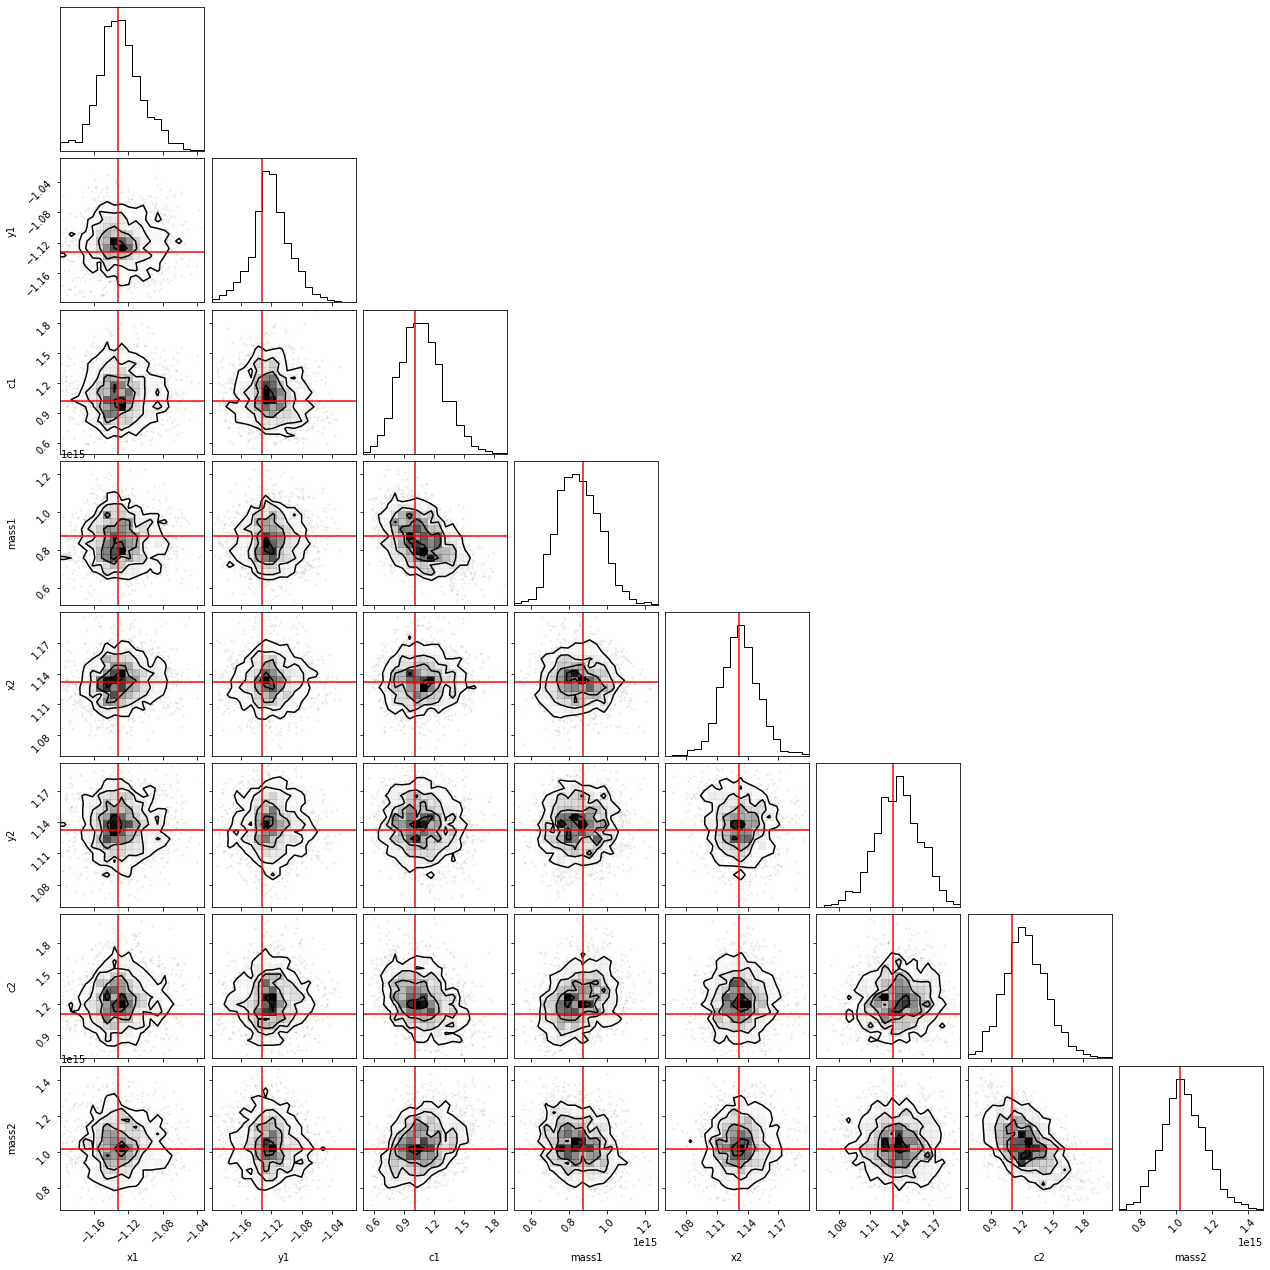

In [44]:
tau = [53.33310366, 46.43600913, 43.25894623, 47.30432492, 52.00833845, 52.73440141,
 44.79150668, 47.61029363] #sampler2.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler2.get_chain(discard=burnin, flat=False, thin=thin)

all_samples = np.concatenate(samples)

labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[-1.132, -1.132, 1.013, 8.7e14, 1.132, 1.132, 1.109, 10.2e14], color='red')

# noise = 0.10

100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s]


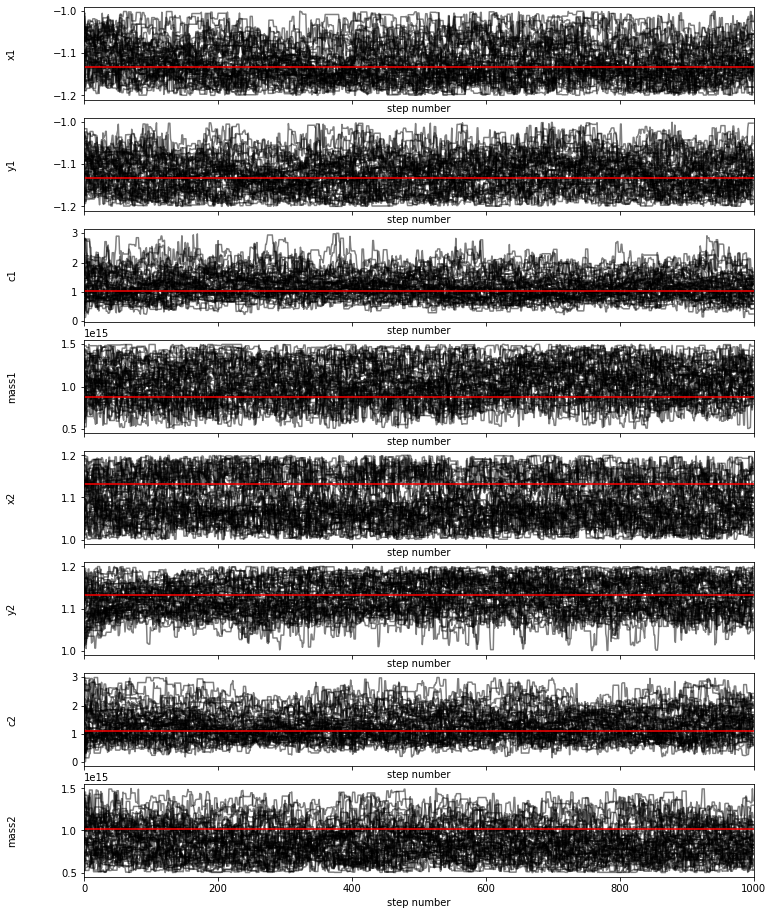

In [46]:
sampler3 = mcmc_and_plot(0.10)

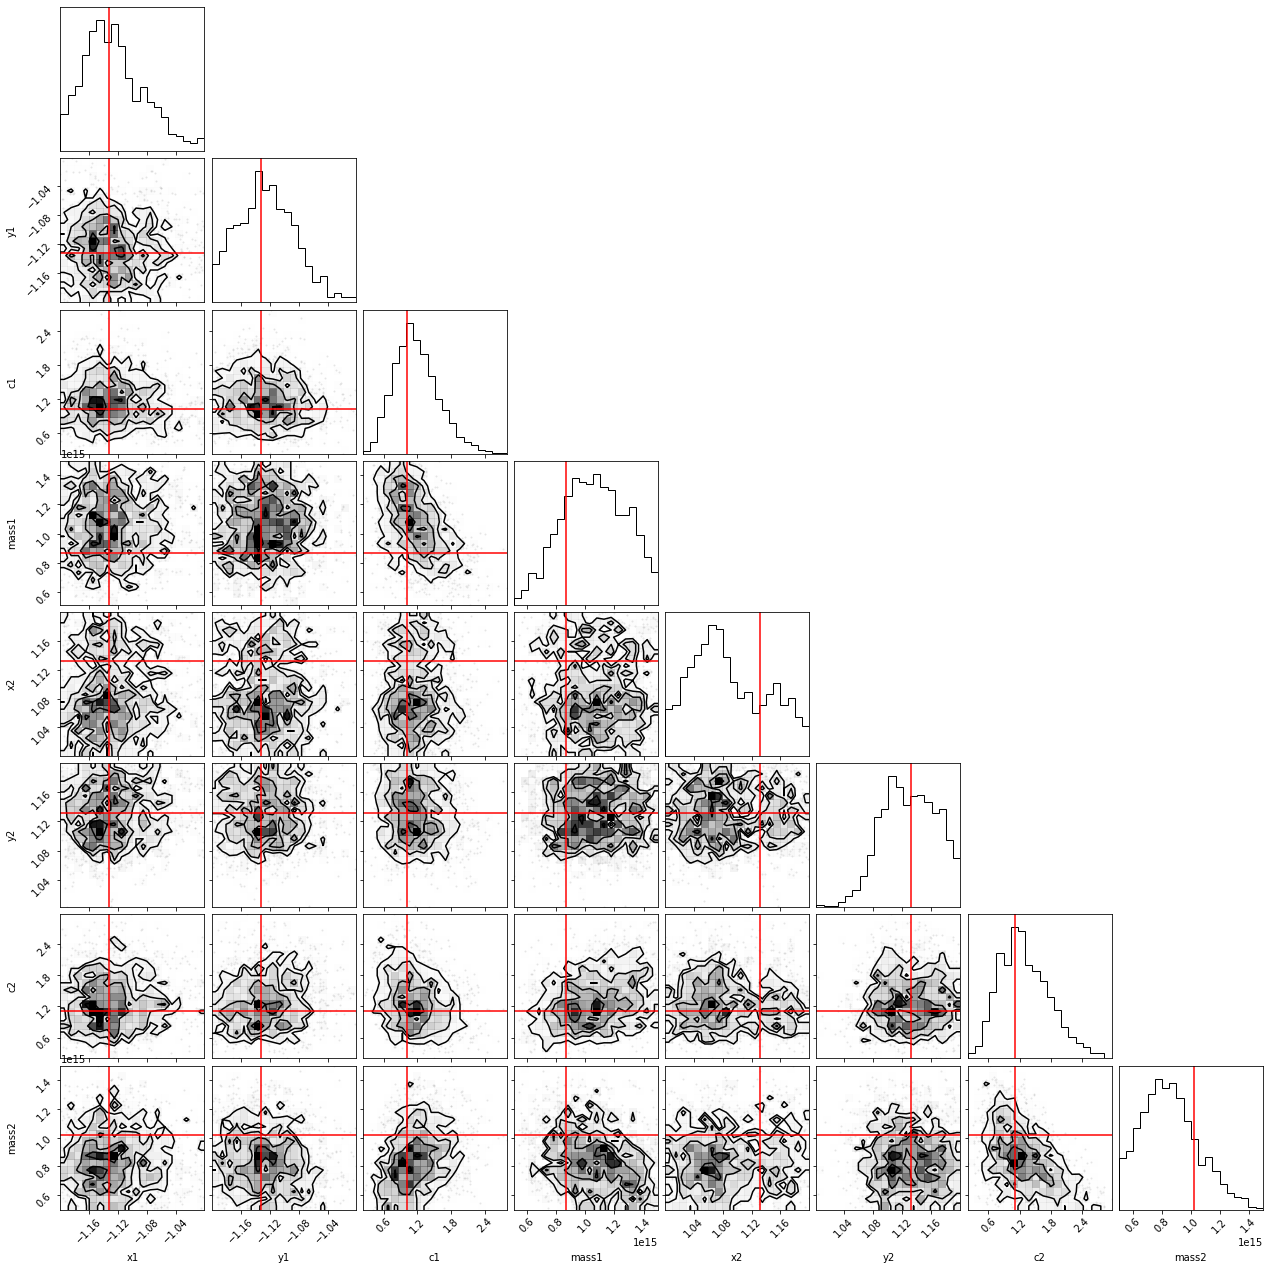

In [51]:
tau = [60.23292108, 61.0875927,  59.60150084 ,55.40662817, 60.43029888 ,68.88372657,
 53.38208441, 64.63385258] #sampler3.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler3.get_chain(discard=burnin, flat=False, thin=thin)

all_samples = np.concatenate(samples)

labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[-1.132, -1.132, 1.013, 8.7e14, 1.132, 1.132, 1.109, 10.2e14], color='red')

# noise = 0.20

100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]


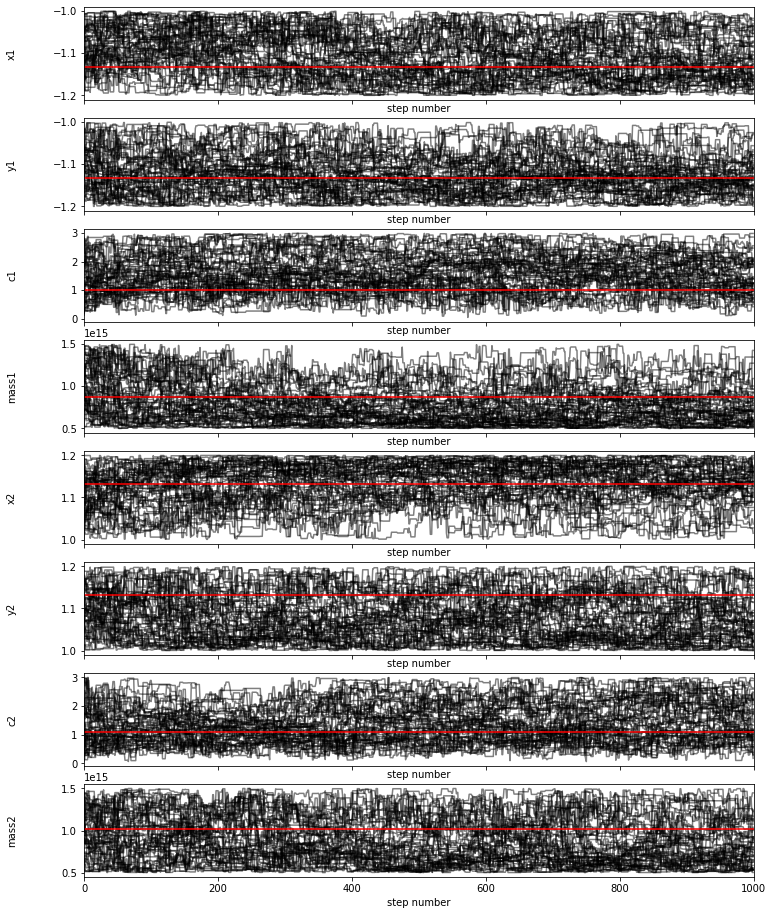

In [47]:
sampler4 = mcmc_and_plot(0.20)

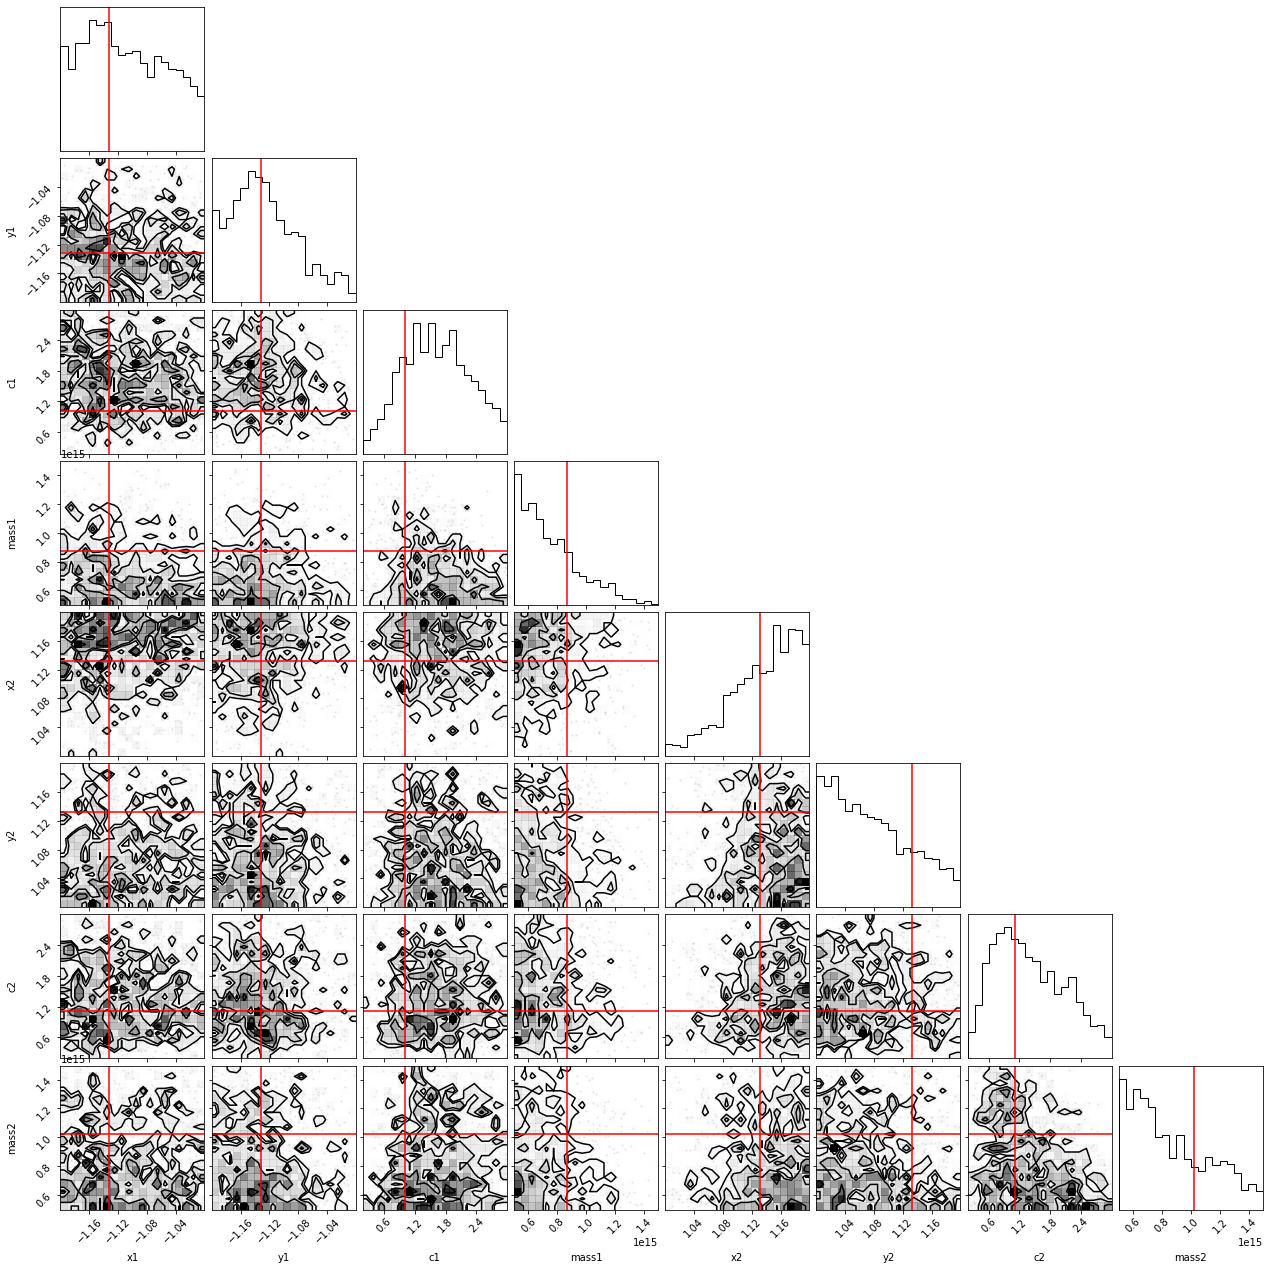

In [55]:
tau = [78.55816437, 76.64045908, 74.331801 ,  83.71945323 ,85.10426443, 81.68106863,
 83.97803359, 83.09386044]
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler4.get_chain(discard=burnin, flat=False, thin=thin)

all_samples = np.concatenate(samples)

labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[-1.132, -1.132, 1.013, 8.7e14, 1.132, 1.132, 1.109, 10.2e14], color='red')

# noise = 0.25

100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]


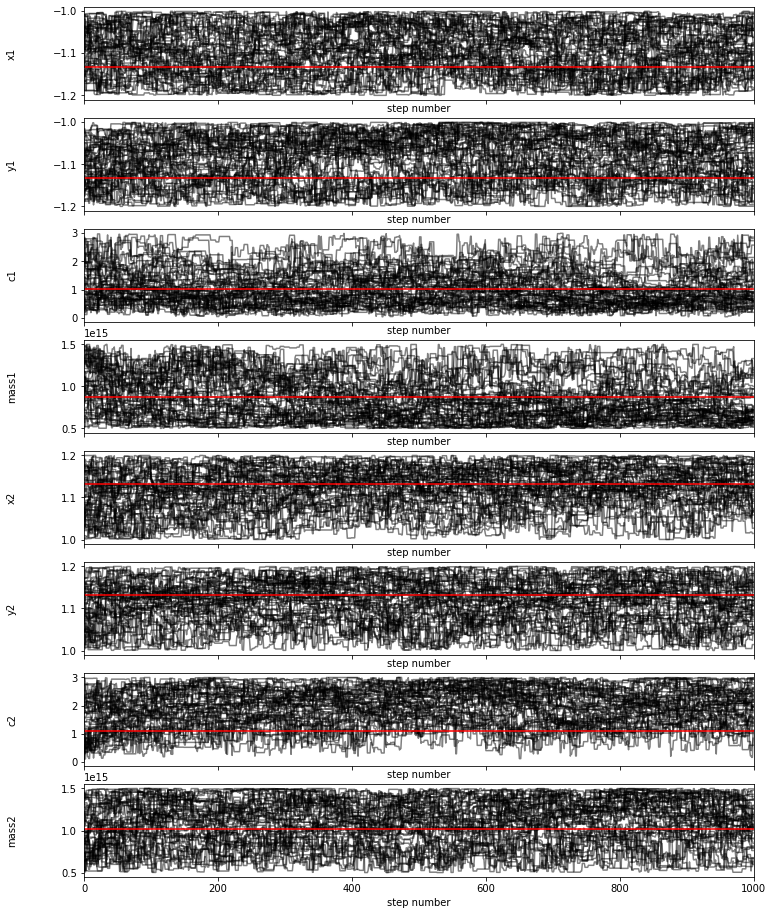

In [48]:
sampler5 = mcmc_and_plot(0.25)

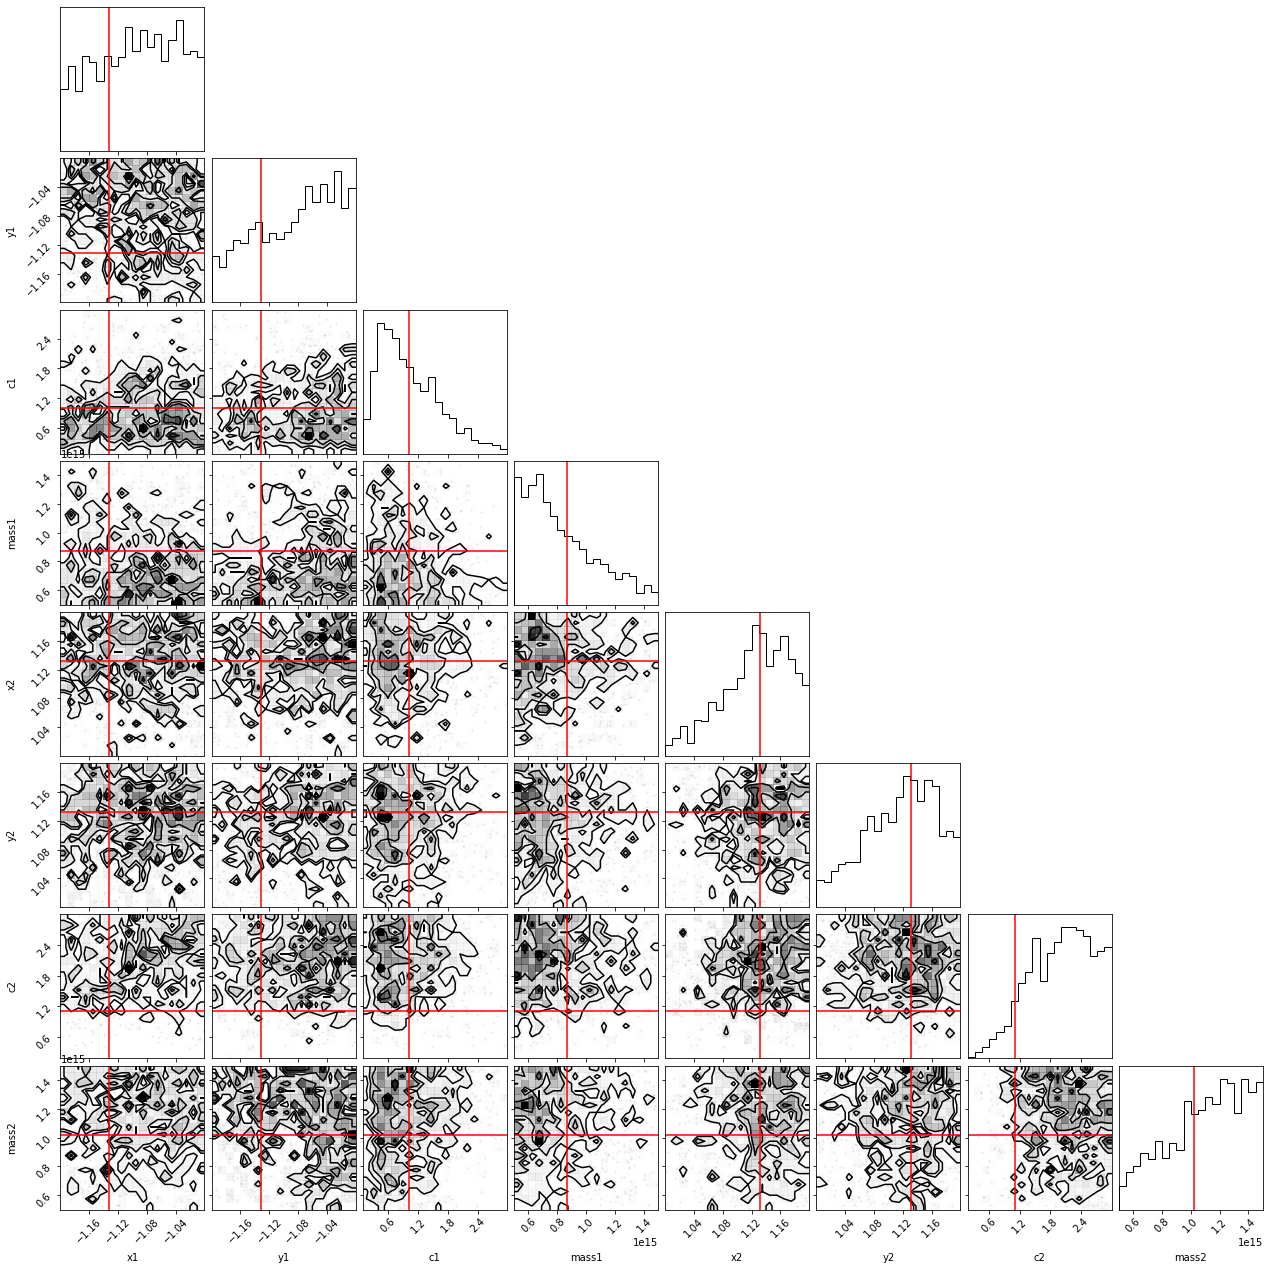

In [53]:
tau = [92.34710079, 86.40943786, 87.77969369, 88.99359434, 79.45989265, 85.88690333,
 85.09974337 ,70.51445603]
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler5.get_chain(discard=burnin, flat=False, thin=thin)

all_samples = np.concatenate(samples)

labels = ["x1", "y1", "c1", "mass1", "x2", "y2", "c2", "mass2"]

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[-1.132, -1.132, 1.013, 8.7e14, 1.132, 1.132, 1.109, 10.2e14], color='red')

# error vs. noise

In [56]:
c1_stds = []
m1_stds = []
c2_stds = []
m2_stds = []
noises = [0.01, 0.05, 0.10, 0.20, 0.25]
all_samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

burnin = 400 

for i in range(len(all_samplers)):
    c1_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 2]))
    m1_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 3]))
    c2_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 6]))
    m2_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 7]))

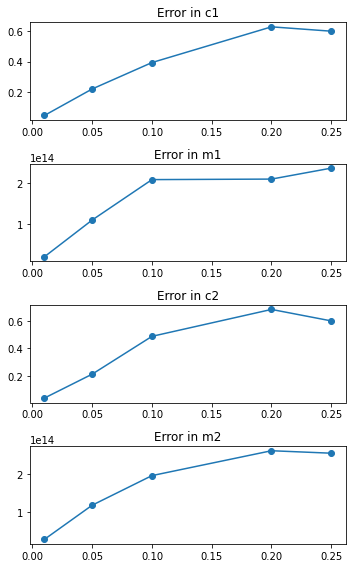

In [86]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(5, 8))
ax1.plot(noises, c1_stds, 'o-')
ax1.set_title('Error in c1')
ax2.plot(noises, m1_stds, 'o-')
ax2.set_title('Error in m1')
ax3.plot(noises, c2_stds, 'o-')
ax3.set_title('Error in c2')
ax4.plot(noises, m2_stds, 'o-')
ax4.set_title('Error in m2')
fig.tight_layout()

## add ellipticity

In [236]:
run functions.py

In [237]:
z_lens1 = 0.071806
z_source1 = 0.1609
x1 = -1.132 # Mpc
y1 = -1.132 # Mpc
Dl1 = cosmo.angular_diameter_distance(z_lens1)

A399 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x1, y0=y1, c=1.013, M=8.7E14, z_lens=z_lens1, z_source=z_source1, e1=1, e2=0.92)

In [238]:
z_lens2 = 0.073664
z_source2 = 0.1609
x2 = 1.132 # Mpc
y2 = 1.132 # Mpc
Dl2 = cosmo.angular_diameter_distance(z_lens2)

A401 = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x2, y0=y2, c=1.109, M=10.2E14, z_lens=z_lens2, z_source=z_source2, e1=1, e2=0.898)

In [239]:
# from Morphology parameters paper
a401_ellip = 0.102 # = 1 - b/a
a399_ellip = 0.080

In [240]:
# to find b
(0.080 - 1) * -1

0.92

In [241]:
combined_kappa = A399 + A401

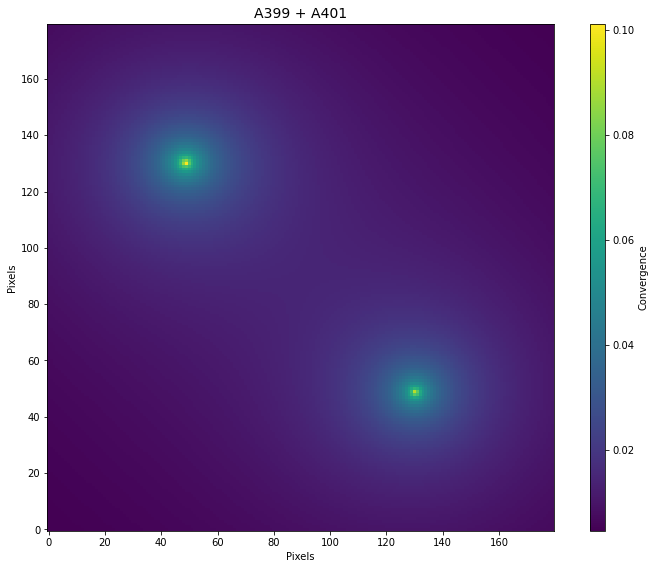

In [242]:
utils1.plot_image(image=combined_kappa, title='A399 + A401', interval_type='simple_norm', cbar_label="Convergence")